# Mount drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [3]:
!pip install lime

     |████████████████████████████████| 275 kB 4.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=620f4ee8469130ccfc96dc19f70ba0ab9546ae4ea0a5e6fd3e166426cf0b6eb8
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [4]:
!pip install shap

     |████████████████████████████████| 564 kB 4.3 MB/s 


In [5]:
import os
import datetime
import time
import timeit
import json

import pandas as pd
import numpy as np

# vis
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline


#dropdown
import ipywidgets as widgets
import IPython
from IPython.display import Image
from IPython.core.display import display, HTML
from ipywidgets import interact, interactive, fixed, interact_manual

# deep learning
import tensorflow as tf
from tensorflow import keras
from keras.applications import inception_v3 as inc_net
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
from skimage.segmentation import mark_boundaries

# xai
import shap

%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [6]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [7]:
folder_deep_weeds = 'drive/MyDrive/Industrial_Applications_of_AI/Primary_Sector/DeepWeeds'
data_folder = 'drive/MyDrive/Industrial_Applications_of_AI/Primary_Sector/DeepWeeds/data'
models_folder = 'drive/MyDrive/Industrial_Applications_of_AI/Primary_Sector/DeepWeeds/models'

In [8]:
def loadModelAndResuls(directory):
  model = tf.keras.models.load_model(os.path.join(models_folder,directory, 'model.h5'))
  results_combined = pd.read_csv(os.path.join(models_folder,directory, 'predictions.csv'))
  return model, results_combined

Use Lime
https://towardsdatascience.com/idea-behind-lime-and-shap-b603d35d34eb

Main paper: https://www.kdd.org/kdd2016/papers/files/rfp0573-ribeiroA.pdf / https://proceedings.neurips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf

# Tutorial Lime

https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb

In [9]:
inet_model = inc_net.InceptionV3()


96124928/96112376 [==============================] - 0s 0us/step


In [10]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)


# Let's see the top 5 prediction for some image


In [11]:
images = transform_img_fn([os.path.join(data_folder,'test_dog','cat-dog.jpg')])

49152/35363 [=========================================] - 0s 0us/step
('n02099712', 'Labrador_retriever', 0.321128)
('n02099267', 'flat-coated_retriever', 0.2523242)
('n02111277', 'Newfoundland', 0.064748555)
('n02099849', 'Chesapeake_Bay_retriever', 0.04266397)
('n02105412', 'kelpie', 0.036873497)


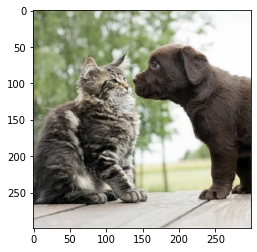

In [12]:
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)


# Explanation

In [13]:
explainer = lime_image.LimeImageExplainer()


In [14]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0].astype('double'), inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 16.4 s, sys: 562 ms, total: 16.9 s
Wall time: 17.5 s


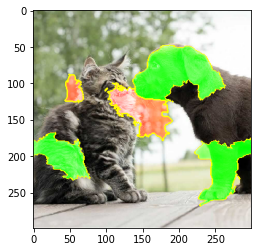

In [15]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


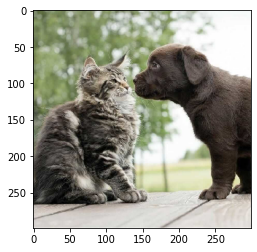

In [16]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


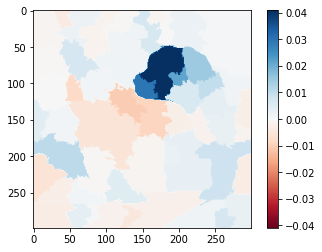

In [17]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()


# Tutorial Shap 

https://shap.readthedocs.io/en/stable/example_notebooks/image_examples/image_classification/Explain%20ResNet50%20using%20the%20Partition%20explainer.html

## Loading Model and Data

In [18]:
# load pre-trained model and data
model = ResNet50(weights='imagenet')
X, y = shap.datasets.imagenet50()

102981632/102967424 [==============================] - 0s 0us/step



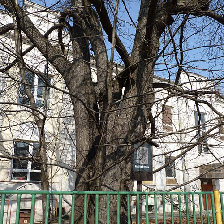

In [19]:
# Image(X[0])

fig1 = px.imshow(X[0])
fig1.show()

In [20]:
#  getting ImageNet 1000 class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]
#print("Number of ImageNet classes:", len(class_names))
#print("Class names:", class_names)


## SHAP ResNet50 model explanation for images

Build a partition explainer with: - the model (a python function) - the masker (a python function) - output names (a list of names of the output classes)



## A quick run with a few evaluations

In [21]:
# python function to get model output; replace this function with your own model function.
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)

# X = images
# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)



In [22]:
f(X)

<tf.Tensor: shape=(50, 1000), dtype=float32, numpy=
array([[4.7311044e-08, 2.4638257e-07, 6.9339890e-08, ..., 2.5136089e-07,
        7.3392807e-06, 1.4682529e-07],
       [8.6282137e-09, 2.4104219e-08, 1.1888291e-08, ..., 6.4619928e-07,
        6.4256682e-07, 3.7792013e-06],
       [2.0467898e-09, 1.5693314e-07, 4.8581302e-07, ..., 7.8900692e-10,
        6.0781544e-09, 1.1030911e-09],
       ...,
       [8.8764142e-07, 7.4206000e-08, 1.0981646e-06, ..., 3.9904188e-07,
        4.1800294e-07, 6.6012522e-06],
       [1.9495534e-05, 1.5395328e-07, 3.7806643e-08, ..., 3.7686807e-06,
        1.0241802e-04, 4.7107251e-06],
       [3.5673870e-11, 3.2258234e-11, 1.4215544e-08, ..., 4.3472689e-10,
        1.2048933e-09, 8.6361700e-09]], dtype=float32)>

In [23]:
# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X[1:3], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

Partition explainer: 3it [00:11, 11.54s/it]               


# Visualizing SHAP values output

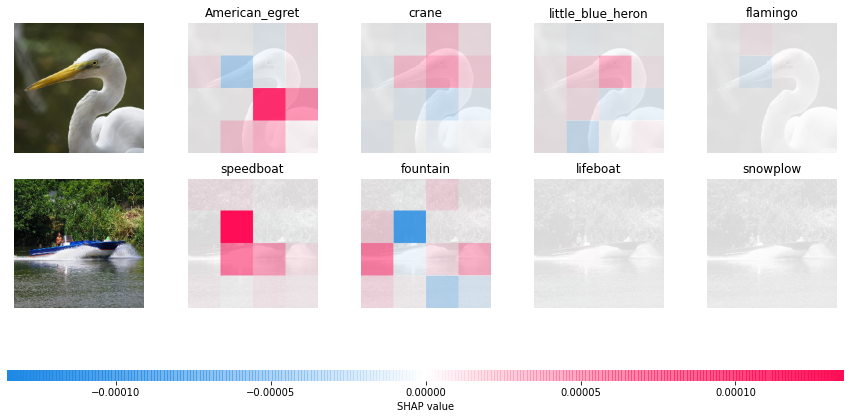

In [24]:
# output with shap values
shap.image_plot(shap_values)

In [25]:
# python function to get model output; replace this function with your own model function.
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", X[0].shape)

# create an explainer with model and image masker
explainer_blur = shap.Explainer(f, masker_blur, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values_fine = explainer_blur(X[1:3], max_evals=5000, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

  0%|          | 0/2498 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/2498 [00:00<?, ?it/s]

Partition explainer: 3it [00:25, 12.59s/it]


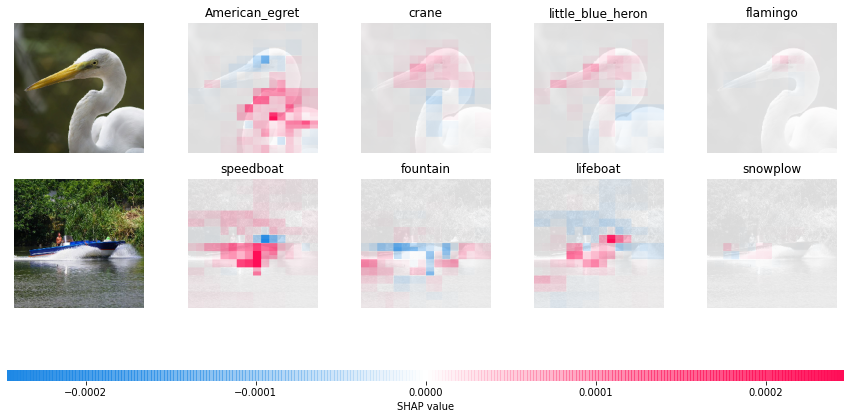

In [27]:
shap.image_plot(shap_values_fine)